# Exam: Numerical Analysis for Machine Learning
## July 8th, 2022

### Exercise 1

These data are the results of a chemical analysis of wines grown in the same region in Italy but derived from three different cultivars, belonging to three different customer segments. The analysis determined the quantities of 13 constituents found in each of the three types of wines.

In [3]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

In [4]:
data = pd.read_csv("https://archive.ics.uci.edu/ml/machine-learning-databases/wine/wine.data", header=None)

A = np.array(data)[:, 1:].astype(np.float64).T  # matrix containing the data (num feats x num wines)
labels = np.array(data)[:, 0].astype(np.int32)  # the label of each wine (i.e. customer segment)

groups = (1, 2, 3)  # customer segments: 1 = low quality, 2 = medium quality, 3 = high quality

features = [
    "Alcohol", "Malic_Acid", "Ash", "Ash_Alcalinity", "Magnesium", 
    "Total_Phenols", "Flavanoids", "Nonflavanoid_Phenols", "Proanthocyanins", 
    "Color_Intensity", "Hue", "OD280", "Proline"
]  #features description


#### 1) How many features? How many samples? How many samples belong to each customer segment?

In [5]:
num_feats = A.shape[0]
num_samples = A.shape[1]

print(f"The number of features is {num_feats}")
print(f"The number of samples is {num_samples}")

customer_segments = {group: A[:, labels == group] for group in groups}

check_sum = 0
for group in groups:
    num_samples_group = customer_segments[group].shape[1]

    print(f"The number of samples for customer segment {group} is {num_samples_group}")

    check_sum += num_samples_group

print(check_sum == num_samples)

The number of features is 13
The number of samples is 178
The number of samples for customer segment 1 is 59
The number of samples for customer segment 2 is 71
The number of samples for customer segment 3 is 48
True


#### 2) Normalize the data so that each feature has zero mean and unitary standard deviation

In [6]:
def get_feature_statistics(matrix, features):
    statistics_per_feat = {
        feat: {
            "mean": np.mean(matrix[i, :]),
            "std": np.std(matrix[i, :])
        }
        for i, feat in enumerate(features)
    }

    return statistics_per_feat

statistics = get_feature_statistics(A, features)
norm_A = A.copy()

for i, feat in enumerate(features):
    norm_A[i, :] -= statistics[feat]["mean"]
    norm_A[i, :] /= statistics[feat]["std"]


new_statistics = get_feature_statistics(norm_A, features)

for feat in features:
    print(f"Previous statistics for: {feat}")
    print(f"--> mean = {statistics[feat]["mean"]}, std = {statistics[feat]["std"]}")
    print(f"New statistics for: {feat}")
    print(f"--> mean = {new_statistics[feat]["mean"]}, std = {new_statistics[feat]["std"]}")
    print("")


Previous statistics for: Alcohol
--> mean = 13.00061797752809, std = 0.8095429145285168
New statistics for: Alcohol
--> mean = -8.382807556720283e-16, std = 1.0

Previous statistics for: Malic_Acid
--> mean = 2.3363483146067416, std = 1.1140036269797893
New statistics for: Malic_Acid
--> mean = -1.197543936674326e-16, std = 1.0

Previous statistics for: Ash
--> mean = 2.3665168539325845, std = 0.27357229442643255
New statistics for: Ash
--> mean = -8.370333140713259e-16, std = 1.0

Previous statistics for: Ash_Alcalinity
--> mean = 19.49494382022472, std = 3.3301697576582128
New statistics for: Ash_Alcalinity
--> mean = -3.991813122247754e-17, std = 1.0

Previous statistics for: Magnesium
--> mean = 99.74157303370787, std = 14.242307673359806
New statistics for: Magnesium
--> mean = -3.991813122247754e-17, std = 1.0

Previous statistics for: Total_Phenols
--> mean = 2.295112359550562, std = 0.6240905641965369
New statistics for: Total_Phenols
--> mean = 0.0, std = 0.9999999999999999

P

#### 3) Perform PCA on the dataset by means of the SVD decomposition. Then plot the trend of:
- the singular value $\sigma_k$

- the cumulate fraction of singular values:  $\frac{\sum_{i=1}^k \sigma_i}{\sum_{i=1}^q \sigma_i}$

- the fraction of the "explained variance": $\frac{\sum_{i=1}^k \sigma_i^2}{\sum_{i=1}^q \sigma_i^2}$

Comment on the results.


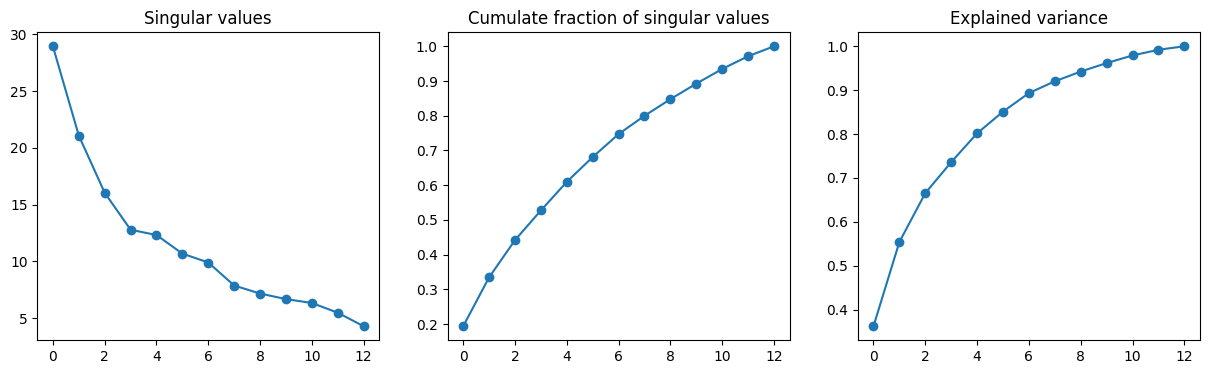

In [7]:
U, S, VT = np.linalg.svd(norm_A, full_matrices=False)

fig, ax = plt.subplots(nrows=1, ncols=3, figsize=(15, 4))

ax[0].plot(S, "o-")
ax[0].set_title("Singular values")

ax[1].plot(np.cumsum(S) / np.sum(S), "o-")
ax[1].set_title("Cumulate fraction of singular values")

ax[2].plot(np.cumsum(S**2) / np.sum(S**2), "o-")
ax[2].set_title("Explained variance")

plt.show()


We observe that the singular values have a sharp drop, and then level off. This may suggest that we might not need every component to significantly explain the data on the table, but only the first few components. This is supported by the 2nd and especially by the third plot, where we see that 90% of the variance the data is explained by the first 6 components. Then, adding more components does not imply a big increase of the explained variance. 

In the end, the results we observe suggest that we may use the first 6 principal components of the data to train a model (i.e., we can reduce the dimensionality of the dataset) while still preserving most of its predictive power. However, although we observe a sharp change in the tendency of the explained variance and the singular values, this may not represent a clear evidence of the benefits of a dim reduction, as components after the 6th may still have valuable information to predict.

#### 4) Compute a matrix containing the principal components associated with the dataset

In [8]:
pc = np.matmul(np.diag(S), VT)  # Or equivalently np.matmul(U.T, norm_A)

print(f"Shape of the principal components matrix: {pc.shape}")

Shape of the principal components matrix: (13, 178)


#### 5) Generate a scatterplot of the first two principal components of the dataset, grouped by label. Draw a line that separates, as well as you manage, the category of low customer segment wines from the rest of the wines (chose intercept and slope of the line by hand, trying to achieve a good result).


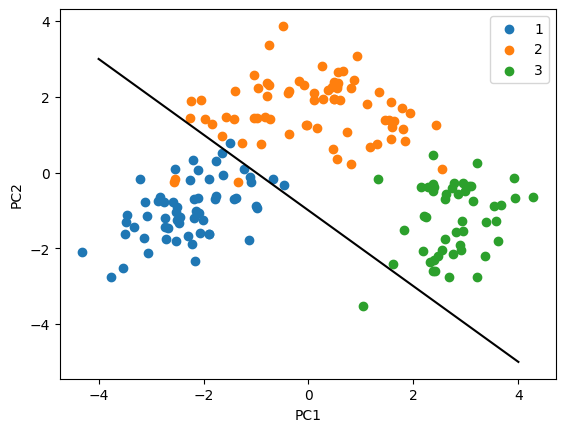

In [9]:
for group in groups:
    plt.scatter(pc[0, labels == group], pc[1, labels == group], label=group)

plt.xlabel("PC1")
plt.ylabel("PC2")
plt.legend()

m = -1
b = -1
x = np.linspace(-4, 4)
y = m * x + b
plt.plot(x, y, color="black")

plt.show()

#### 6) Based on the line of plot 4, define a predictor to detect wines of low customer segment. Then, compute the number of true positives (TP), false positives (FP), true negatives (TN) and false negatives (FN). Finally, compute:

- sensitivity: $(TP) / (TP + FN)$
  
- specificity: $(TN) / (TN + FP)$

- accuracy: $(TP + TN) / (TP + FP + TN + FN)$

In [10]:
pc_dim2 = pc[:2, :]

m = -1
b = -1

# np.dot(w, x) - b > 0 if x is above the line, < 0 if x is below the line, == 0 if x is on the line
w = np.array([-m, 1])  
preds = (np.dot(w, pc_dim2) - b) < 0

group = 1

TP = np.sum(preds[labels == group])
FP = np.sum(preds[labels != group])
TN = np.sum(~preds[labels != group])
FN = np.sum(~preds[labels == group])

print(f"TP: {TP}, FP: {FP}, TN: {TN}, FN: {FN}")

sensitivity = TP / (TP + FN)
specificity = TN / (TN + FP)
accuracy = (TP + TN) / (TP + FP + TN + FN)

print(f"Sensitivity: {sensitivity}")
print(f"Specificity: {specificity}")
print(f"Accuracy: {accuracy}")


TP: 56, FP: 4, TN: 115, FN: 3
Sensitivity: 0.9491525423728814
Specificity: 0.9663865546218487
Accuracy: 0.9606741573033708


#### 

### Exercise 2

Consider the minimization of the 2D quadratic function :
$$f(\mathbf{x}) = \frac{1}{2} (x_1^2 + \eta x_2^2)$$

where $\mathbf{x} = (x_1, x_2)$ and $\eta > 0$. 

#### 1) Use the ``contourf`` command to plot the contourlines of the function for different values of $\eta$; use the following syntax:

```
import numpy as np
import matplotlib.pyplot as plt

x = np.linspace(xmin, xmax, Nx)
y = np.linspace(ymin, ymax, Ny)

[XX, YY] = np.meshgrid(x, y)
F = (XX ** 2 + eta * YY ** 2) / 2

plt.contourf(XX, YY, F, Ncontour)

```

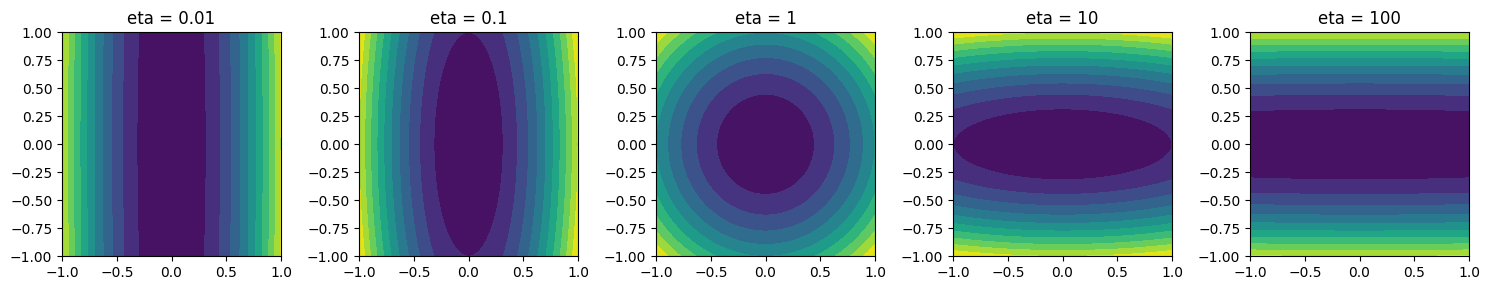

In [11]:
etas = [0.01, 0.1, 1, 10, 100]
f = lambda x1, x2, eta: 0.5 * (x1**2 + eta * x2**2)

xmin = -1
xmax = 1
ymin = -1
ymax = 1

mesh_points = 100
levels = 10

x = np.linspace(xmin, xmax, mesh_points)
y = np.linspace(ymin, ymax, mesh_points)
X, Y = np.meshgrid(x, y)

fig, ax = plt.subplots(nrows=1, ncols=len(etas), figsize=(15, 3))

for i, eta in enumerate(etas):
    Z = f(X, Y, eta)

    ax[i].contourf(X, Y, Z, levels=levels)
    ax[i].set_title(f"eta = {eta}")

plt.tight_layout()
plt.show()

#### 2) How does $\eta$ impact on he numerical solution?

**Answer:**

By the previous graphs, we observe that different values of $\eta$ yield different excentricities of the function level curves. Specifically, we notice that a high value ($>> 1$) or a small value ($<< 1$) produce a high excentricity, either by elongating the x or y axis respectively. 

This shape (greatly elongated ellipse) produces a zigzagging behavior when using the gradient descent algorithm, resulting in a slow convergence. 

This can be formally explained by the condition number. It is calculated by extracting the ratio between the biggest and smallest eigenvalue of the Hessian. The Hessian is the following:

$$H = \begin{bmatrix} 1 & 0 \\ 0 & \eta \end{bmatrix}$$

Notice that the condition number is calculated as follows:

$$\kappa(H) = \frac{\max(1, \eta)}{\min(1, \eta)}$$

Then, for $0 < \eta << 1$ or $\eta >> 1$, the condition number is large, meaning that the problem is ill-conditioned. The convergence of the gradient descent method is dependant of this number, and the bigger it is, the slower the convergence we expect (it also depends on the starting point of the method).

Other methods like Newton's mitigate this problem by adding information onf the curvature of the function, and thus getting a faster convergence.

#### 3) Let us consider the gradient descent (GD) algorithm; the iteration relation is given by:

$$\mathbf{x}^{(k+1)} = \mathbf{x}^{(k)} + \tau_k \nabla f(\mathbf{x}^{(k)})$$

#### with $\tau_k > 0$. In the convex case, if $f$ is of class $C^2$, in order to have convergence, we must have:

$$0 < \tau_k < \frac{2}{\sup_x \|H f(\mathbf{x}) \|}$$

#### where $H f(\mathbf{x})$ is the Hessian of $f$. Compute the maximum value of $\tau_k$ to have convergence

**Answer:**

Notice that the upper bound for $\tau_k$ is:
$$\frac{2}{\sup_x \| H f (x)\|}$$

Then, we need to calculate this value. Notice that:
$$\|H\| = \lambda_{\max}(H)$$

Then: 
$$\|Hf(x)\| = \lambda_{\max}(Hf(x)) = \max(1, \eta)$$

So, the upper bound of $\tau_k$ is:
$$\frac{2}{\max(1, \eta)}$$

When $\eta > 1$ --> $\tau_k = \frac{2}{\eta}$

and when $\eta < 1$ --> $\tau_k = 2$

#### 4) Implement the GD method with constant step size. Assume $\eta = 4$ and $\mathbf{x}_0 = (0.9, 0.3)$. Display the iterations on the contour figure, for diferent values of the step size. Comment on the results.

In [12]:
def grad_descent(
    grad_f: callable, x0: np.ndarray, 
    tau: float, tol: float = 1e-6, max_iter: int = 1000
) -> tuple[np.ndarray, np.ndarray]:
    
    x = x0
    x_prev = x0

    iters = []

    for i in range(max_iter):
        x = x_prev - tau * grad_f(x_prev)
        iters.append(x)

        if np.linalg.norm(x - x_prev) < tol:
            break

        x_prev = x

    return x, np.array(iters)

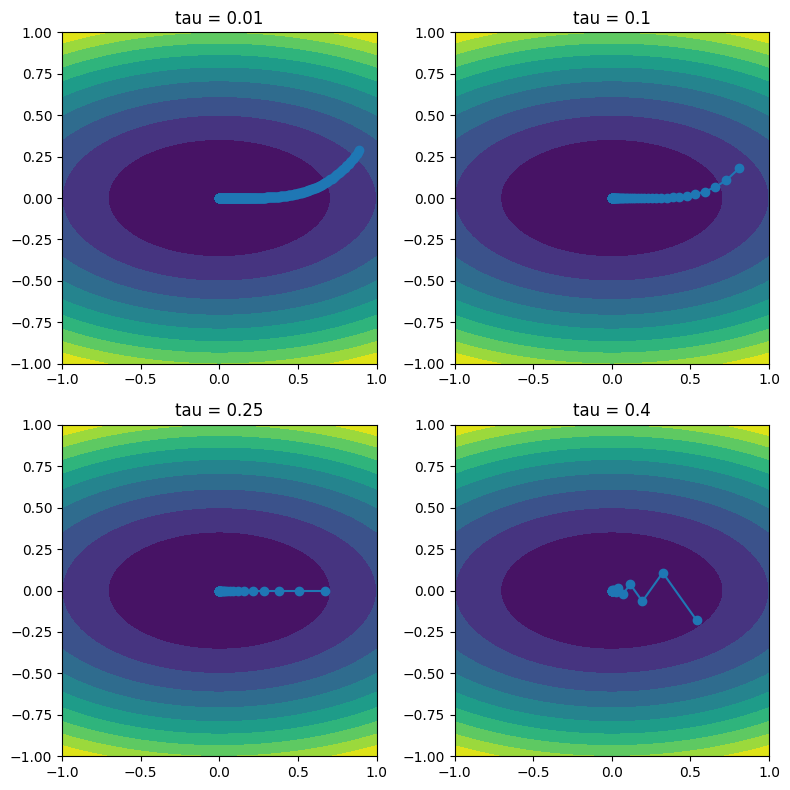

Total number of iterations:
tau = 0.01: 907
tau = 0.1: 110
tau = 0.25: 44
tau = 0.4: 28


In [13]:
grad_f = lambda x, eta: np.array([x[0], eta * x[1]])

x0 = np.array([0.9, 0.3])
eta = 4

taus = [0.01, 0.1, 0.25, 0.4]

fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(8, 8))
ax = ax.flatten()

x = np.linspace(xmin, xmax, mesh_points)
y = np.linspace(ymin, ymax, mesh_points)
X, Y = np.meshgrid(x, y)

Z = f(X, Y, eta)

total_iters = []

for i, tau in enumerate(taus):
    x_opt, iters = grad_descent(
        grad_f=lambda x: grad_f(x, eta), x0=x0, tau=tau
    )

    total_iters.append(len(iters))

    ax[i].contourf(X, Y, Z, levels=levels)
    ax[i].plot(iters[:, 0], iters[:, 1], "o-")
    ax[i].set_title(f"tau = {tau}")

plt.tight_layout()
plt.show()


print("Total number of iterations:")
for i, tau in enumerate(taus):
    print(f"tau = {tau}: {total_iters[i]}")



We can observe different results for different values of $\tau$:

For $\tau = 0.01$ we observe a slow convergence. There are a lot of iteration points, meaning that the algorithm takes longer to converge to a solution. This is due to the fact that the step size is too small, causing that between iterations, we move relatively close to the previous point.

For $\tau = 0.1$ we observe a slightly faster convergence. The bigger step size is more noticeable on the first steps. However, as we approach the minimum, the steps become smaller (as the gradient norm gets smaller) and thus resulting in many iterations near the optimum.

For $\tau = 0.25$ we observe a faster convergence, taking less than half of iterations needed before. Also, we observe a stable convergence, with little to none zigzagging, and a faster approach to the minimum due to the larger size of the step.

For $\tau = 0.4$ we observe the fastest convergence. This value is the closest of all to the theoretical upper bound needed to assure convergence. We notice that fact in the velocity of the convergence. However, the behavior of the algorithm seems to be a little more unstable, showing a clear zigzagging between iterations. We still guarantee the convergence by having a step smaller than $2/4 = 0.5$, so we still reach the optimum.

#### 5) Consider the exact line search method for the dynamic choice of the step size. IN this method at each step we choose:
$$\tau_k = \text{argmin}_s f(\mathbf{x}^{(k)} - s \nabla f (\mathbf{x}^{(k)}))$$

#### Compute the explicit expression of $\tau_k$ given by the exact line search method for the previous function.

**Answer:**

To calculate the value of $\tau_k$, let us define the following functions:
$$\mathbf{y}_k(s) = \mathbf{x^{(k)}} - s \nabla f(\mathbf{x}^{(k)})$$
$$h_k(s) = f(\mathbf{y}_k(s))$$

Then, note that $h_k$ is an univariate function, so we can use a basic optimization process:
$$h'_k(s) = 0$$

From now on, we will omit the $k$ index:

$$h'(s) = \nabla f(\mathbf{y}(s)) \cdot \mathbf{y}'(s)$$
$$= -\nabla f(\mathbf{y}(s)) \cdot \nabla f(\mathbf{x})$$

$$-((1-s) x_1, (1 - \eta s) \eta x_2) \cdot (x_1, \eta x_2)$$
$$= (s - 1)x_1^2 + (\eta s - 1) \eta^2 x_2^2$$

Then:

$$h'(s) = 0 \iff (s - 1)x_1^2 + (\eta s - 1) \eta^2 x_2^2 = 0$$
$$\iff (x_1^2 - \eta^3 x_2^2)s = x_1^2 + \eta^2 x_2^2$$

$$\iff s = \frac{x_1^2 + \eta^2 x_2^2}{x_1^2 + \eta^3 x_2^2}$$

This is the expression for the exact value of the step, using exact line search method.

#### 6) Implement the GD method with variable step size using the expression derived at the previous point and apply the method to the minimization of function (1). Display the iterations on the contour figure. Comment on the results.

In [14]:
def grad_descent_exact(
    grad_f: callable, x0: np.ndarray,
    tau: callable, tol: float = 1e-6, max_iter: int = 1000
):
    
    x = x0
    prev_x = x0

    iters = []
    for i in range(max_iter):
        x = prev_x - tau(prev_x) * grad_f(prev_x)
        iters.append(x)

        if np.linalg.norm(x - prev_x) < tol:
            break

        prev_x = x

    return x, np.array(iters)

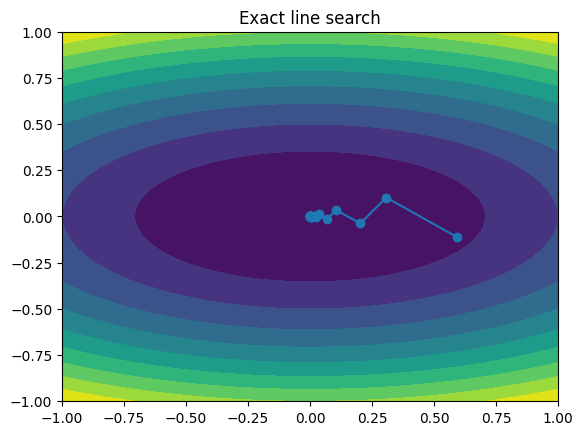

Number of iterations: 26


In [16]:
grad_f = lambda x, eta: np.array([x[0], eta * x[1]])
tau = lambda x, eta: (x[0]**2 + eta**2 * x[1]**2) / (x[0]**2 + eta**3 * x[1]**2)

x0 = np.array([0.9, 0.3])
eta = 4

x_opt, iters = grad_descent_exact(
    grad_f=lambda x: grad_f(x, eta), x0=x0, tau=lambda x: tau(x, eta)
)

x = np.linspace(xmin, xmax, mesh_points)
y = np.linspace(ymin, ymax, mesh_points)
X, Y = np.meshgrid(x, y)

Z = f(X, Y, eta)

plt.contourf(X, Y, Z, levels=levels)
plt.plot(iters[:, 0], iters[:, 1], "o-")
plt.title("Exact line search")
plt.show()

print(f"Number of iterations: {len(iters)}")


We observe that in this case, the number of iterations needed for achieving the same precision as before is less than the previous experiments. This is because we are moving exactly the amount needed to achieve the minimum point at each descent direction. We observe also the typical zigzagging behavior of the gradient descent, that is expected due to the shape (excentricity) of the level curves of the function.